Contents:
* Summary
* How to run this document
* EDA
* Data Cleaning
* Model Hypotheses
* Training models
* Model Choice and Evaluation
* API (very simple and not needed)
* Further Improvements

# Summary (if you don't want to read all of this document)
This is a list of all my important notes, observations, and conclusions
* Training set contains many duplicates signaled by the low number of unique values for the numerical categories => reduced to 490 examples. They were probably originally less, but missing values made duplicate rows different.
* The training and validation sets are not iid which is a huge issue as it could negate any work done on the training set. I decided to use part of the validation (50 from the 200 examples) only to make sure features from both sets have the same distributions.
* variable19 has 1 to 1 correlation with target in the training set but 0 correlation in the validation set => it will be dropped. All other features has similar correlations in the training set compared to the validation set.
* variable4 is a duplicate of variable5 with different characters => drop variable5
* variable17 = variable14x10000 => drop variable17
* The dataset is most probably synthetic, with variable9 or variable10 probably being the main feature related to the target (highest correlation with target). Other features were randomly generated with no correlation to the target (variable12, variable13, variable14, second value in variable 2). Some values were replaced with random values (Ex: variable9 probably has 10-20% of its values replaced with random values). Finally, nulls were added randomly to the features.
* Because of the correlations between features (mainly variable9) and the target, all models perform similarly at around 86% accuracy; any deviation from it is probably model variance.
* Using this information, a 1 line model was created (kind of for fun😅) that acheives results comparable to SVM, logistic regression, and the other models. This was a result of variable9 having good correlation with the target and all other variables having high intercorrelations and not providing any information about the targets.


# How to run
* It is recommended to run on google colab
* Upload both the training.csv and validation.csv to the default location in colab '/content/'
* Now you should have '/content/training.csv' and '/content/validation.csv'
* Run the code😄
* To run the API section, please insert the API key sent to you by email were shown (to prevent leaking the data or model to the public)

# EDA
## Main Observations
* Many duplicates reduced effective training data from 3700 to 490. There are probably more duplicates hidden by the missing values.
* variable19 has 1 to 1 correlation with targets in training set but no correlation in validation set => Big problem because this means training and validation sets are not iid. Need to be careful and will drop variable19
* variable4 and variable5 are duplicates, same for variable14 and variable17
* There is probably a better way to divide variable2's entries because the histogram shows a mixture of 2 distinctly separate gaussians (see Quick Observation 4).

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv("training.csv",delimiter=';').sample(frac=1).reset_index(drop=True) # Random shuffling to ensure iid distribution
print(df.shape)
df.head(3)

(3700, 19)


,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable17,variable18,variable19,classLabel
0,b,"25,5","3,75e-05",u,g,m,v,"0,25",t,t,3,f,g,260.0,15108,2600000.0,t,1,yes.
1,b,"35,17","0,0025125",u,g,x,h,"1,625",t,t,1,t,g,515.0,500,5150000.0,NaN,1,yes.
2,b,"54,58","0,0009415",u,g,ff,ff,"14,415",t,t,11,t,g,30.0,300,300000.0,NaN,1,yes.


In [2]:
df.nunique().values # Interesting, numerical features don't have many unique values => discretized or duplicates

array([  2, 288, 179,   3,   3,  14,   9, 118,   2,   2,  23,   2,   3,
       136, 182, 136,   2,   2,   2])

In [3]:
dropped_df = df.drop_duplicates()
print(dropped_df.shape)
dropped_df.nunique().values # Turns out it was duplicates

(490, 19)


array([  2, 288, 179,   3,   3,  14,   9, 118,   2,   2,  23,   2,   3,
       136, 182, 136,   2,   2,   2])

In [4]:
dropped_df.isnull().sum().values # Leave variable18 for now because of large number of nulls (will analyze later)

array([  9,   9,   0,   4,   4,   6,   6,   0,   0,   0,   0,   0,   0,
        10,   0,  10, 270,   0,   0])

In [5]:
df['variable11'].unique() # Looks to be numerical not categorical

array([ 3,  1, 11,  0,  5, 12,  4,  7, 17,  2,  9, 16, 67,  6,  8, 19, 20,
       15, 14, 13, 10, 40, 23])

In [6]:
# Adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def draw_matrix_heatmap(mat,x_labels,y_labels,title,ax):
  """ Functions used to plot a matrix as a heatmap

  Args:
    mat (2d numpy array): matrix to graph
    x_labels (list of str): names of the labels on the x axis
    y_labels (list ot str): names of the labels on the y axis
    title (str): title to add at the top of the subplot
    ax (matplotlib subplot): subplot used to plot the graph in
  
  Returns:
    None

  """
  im = ax.imshow(mat)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(x_labels)))
  ax.set_yticks(np.arange(len(y_labels)))

  # ... and label them with the respective list entries
  ax.set_xticklabels(x_labels)
  ax.set_yticklabels(y_labels)

  # Loop over data dimensions and create text annotations.
  for i in range(len(y_labels)):
      for j in range(len(x_labels)):
          text = ax.text(j, i, mat[i, j],
                        ha="center", va="center", color="w")

  ax.set_title(title)

def get_probs(df_with_targets,col_data,ax):
  """ Find the conditional probabilities for p(yes) and p(no) given each possible value in col
  
  Args:
    df_with_targets (pd.DataFrame): dataframe containing the targets and column comparing with
    col_data (pd.Series): pandas Series containing the column used to compare with targets
    ax (matplotlib subplot): subplot used to plot the graph in

  Returns:
    None
  """
  prob_yes = [] # Will contain p(yes|.)
  prob_no = [] # Will contain p(no|.)

  # Calculate conditional probabilities
  for c in np.unique(col_data.values):
    prob_yes.append(  df_with_targets[col_data==c].sum()  )
    prob_no.append(  (1-df_with_targets[col_data==c]).sum() )
  
  mat = np.array([prob_yes,prob_no])

  # Draw calculated probabilities
  draw_matrix_heatmap(mat, np.unique(col_data.values), ["P(yes given ","P(no given"],col_data.name,ax)

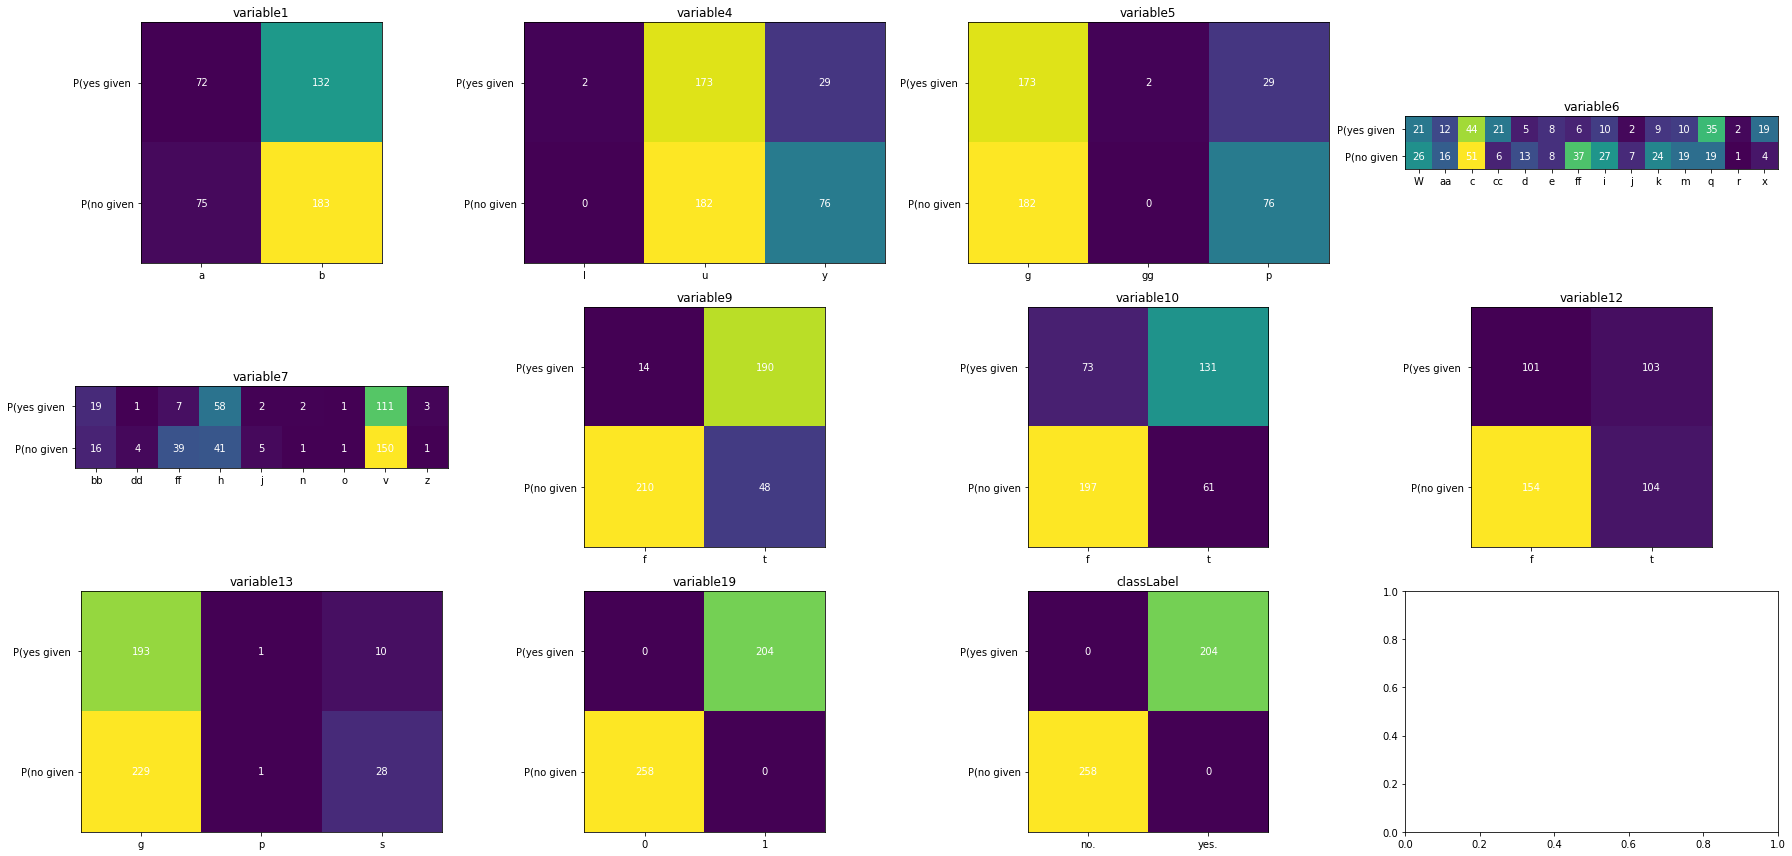

In [7]:
# Estimate correlations between categorical features and binary target (using conditional probabilities)

dropped_no_null_df = dropped_df.drop('variable18',axis=1).dropna() # Will analyze variable18 later
is_feature_categorical = dropped_no_null_df.nunique()<20

target = dropped_no_null_df['classLabel'].map({'yes.':1,'no.':0})

fig, axs = plt.subplots(3,4,figsize=(25,12))

for idx,c in enumerate(dropped_no_null_df.columns[is_feature_categorical]): # Loop through all categorical features
  get_probs(target,dropped_no_null_df[c],axs[idx//4][idx%4]) # Plot correlation with target using conditional probabilities
  
fig.tight_layout()
plt.show()

### Important observation 1
variable19 has 1 to 1 correlation with target variable. This seems suspicious. If it was true, the problem is not a problem. Most probably, something wrong happened during data collection (or it was placed there intentionally😏). Need to make sure the same is in the validation set (ensure training and validation are iid).
<br>
I will use part of the validation to check for this (50 from the 200 examples)



### Quick observation 1
variable4 and variable5 are copies of each other which was validated by cross checking them, so I will drop variable5.

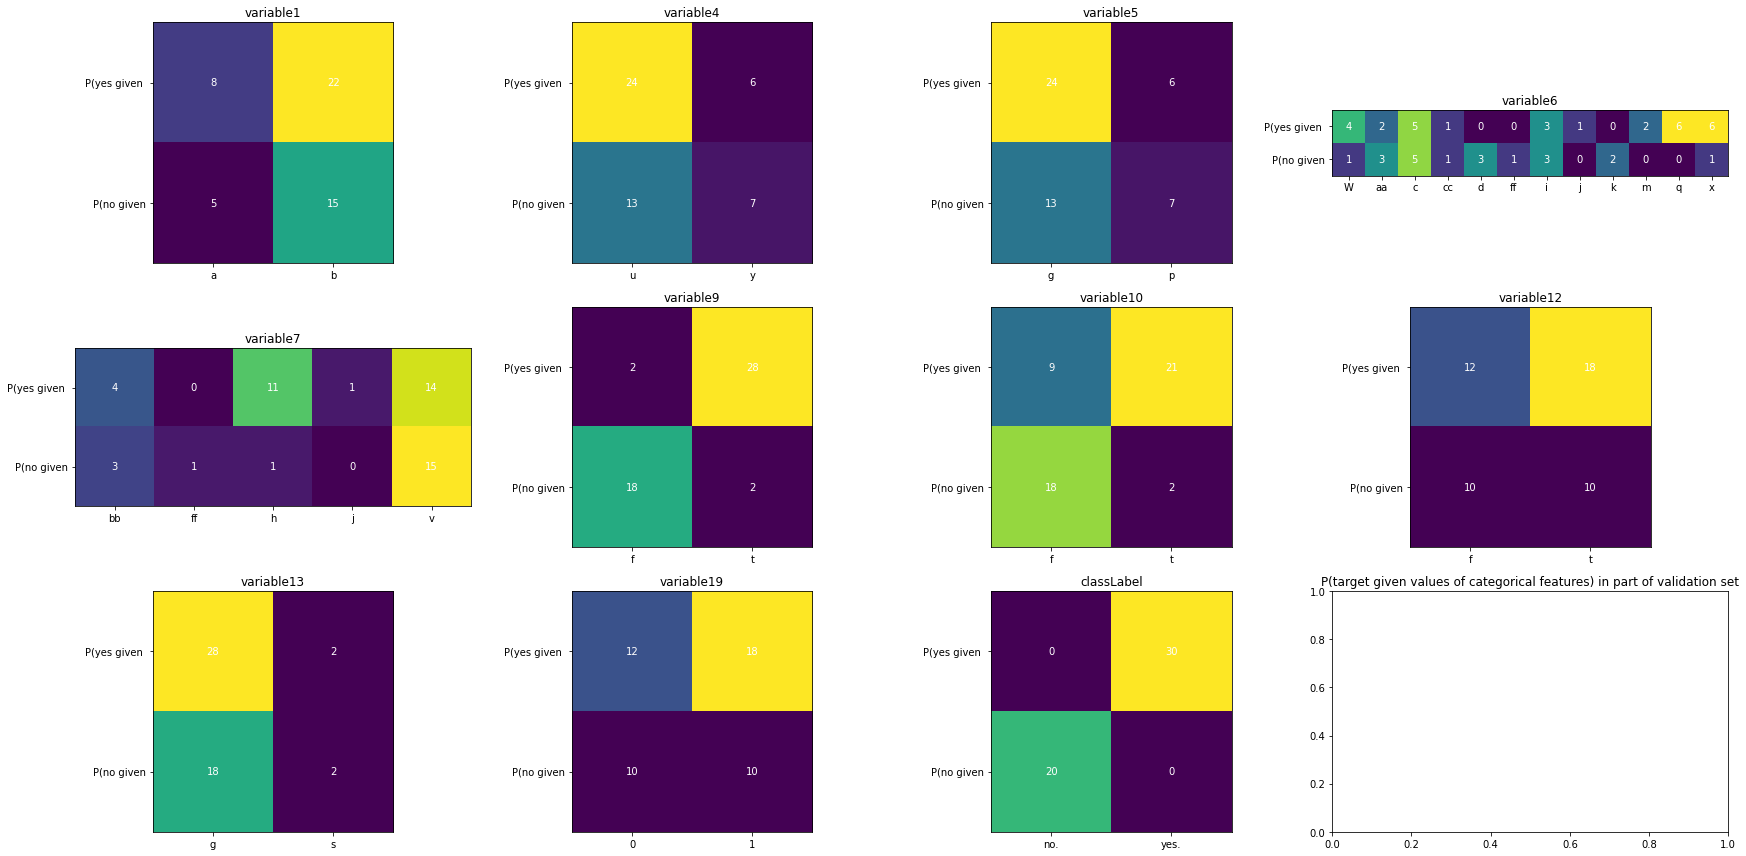

In [8]:
# Checking validation distributions for categorical features

np.random.seed(1) # to always choose the same 50 from the validation to use in EDA
val_df = pd.read_csv("validation.csv",delimiter=';').sample(frac=1).reset_index(drop=True) # Random shuffling to ensure iid distribution
dropped_val_df = val_df.drop_duplicates() # To make sure if duplicates exist, they don't affect EDA as duplicates were dropped in training

dropped_no_null_val_df = dropped_val_df.drop('variable18',axis=1).dropna().iloc[:50] # Will analyze variable18 later

target_val = dropped_no_null_val_df['classLabel'].map({'yes.':1,'no.':0})

fig, axs = plt.subplots(3,4,figsize=(25,12))
plt.title("P(target given values of categorical features) in part of validation set")
for idx,c in enumerate(dropped_no_null_val_df.columns[is_feature_categorical]):
  get_probs(target_val,dropped_no_null_val_df[c],axs[idx//4][idx%4])
  
fig.tight_layout()
plt.show()

## Important observation 1 (concluded)
Turns out it was like I suspected; in the validation set, variable19 has almost 0 correlation with the target label. Other features seem to have similar correlations comprared to the correlations in the training set.
<br>
So, I will drop variable19 from both sets

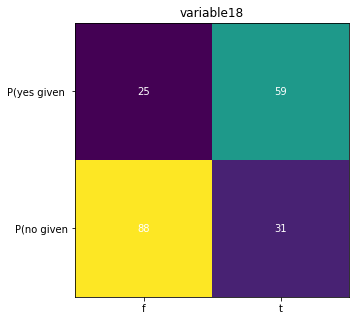

In [9]:
# Analyzing variable18 in training set
df_var18 = dropped_df.dropna()
target = df_var18['classLabel'].map({'yes.':1,'no.':0})
fig, axs = plt.subplots(1,figsize=(5,5))

get_probs(target,df_var18['variable18'],axs)
  
fig.tight_layout()
plt.show()

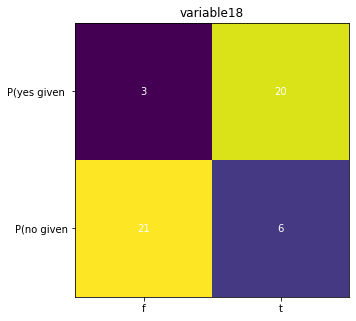

In [10]:
# Analyzing variable18 in validation set

df_var18_val = dropped_val_df.dropna().iloc[:50]

target = df_var18_val['classLabel'].map({'yes.':1,'no.':0})
fig, axs = plt.subplots(1,figsize=(5,5))

get_probs(target,df_var18_val['variable18'],axs)
  
fig.tight_layout()
plt.show()

## Quick Observation 2
variable18 has many nulls but still has correlation with targets so will keep it and replace nulls with a new third category.

In [11]:
# Cleaning Numerical Categories to analyze


def clean_string_floats(element):
  """ If element is string, parse it into a float, else return it

  Args:
    element (str or float): element to parse

  Returns:
    float: parsed element
  """
  if type(element) is str:
    element = element.replace(",",".")
  return float(element)

def clean_variable2(col):
  """ Specific function for variable2, it splits (a,b) into 2 separate columns.
  If one element is present in a row, the same value is placed into the 2 columns (same with null values)

  Args:
    col (pd.Series, np.array, or list): variable2 data

  Returns:
    col1 (list): First column of the 2 separated ones
    col2 (list): Second column of the 2 separated ones
  """
  col1 = []
  col2 = []

  for element in col:
    if type(element) is str and "," in element: # (a,b) case
      col1.append(float(element.split(",")[0]))
      col2.append(float(element.split(",")[1]))
    elif element is not None: # Not null but only one value case
      col1.append(float(element))
      col2.append(float(element))
    else: # null case
      col1.append(None)
      col2.append(None)
      
  return col1,col2

In [ ]:
# Prepare Numerical Categories for Analysis
dropped_df['variable2_1'],dropped_df['variable2_2'] = clean_variable2(dropped_df['variable2'])
dropped_df['variable3'] = dropped_df['variable3'].apply(clean_string_floats)
dropped_df['variable8'] = dropped_df['variable8'].apply(clean_string_floats)

dropped_val_df['variable2_1'],dropped_val_df['variable2_2'] = clean_variable2(dropped_val_df['variable2'])
dropped_val_df['variable3'] = dropped_val_df['variable3'].apply(clean_string_floats)
dropped_val_df['variable8'] = dropped_val_df['variable8'].apply(clean_string_floats)

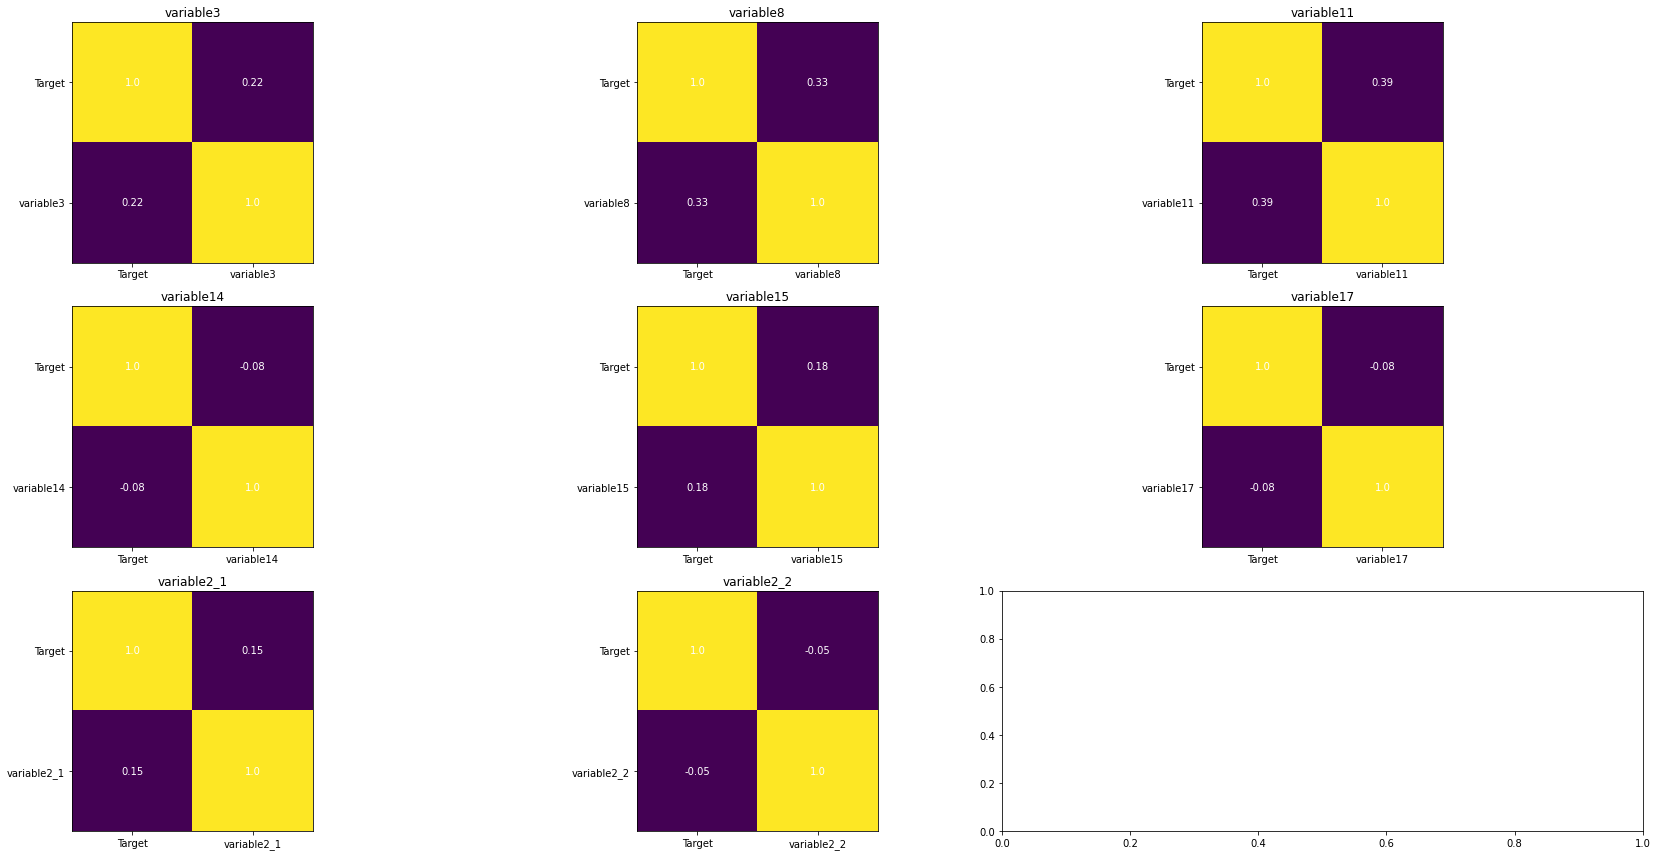

In [13]:
dropped_no_null_df = dropped_df.drop(['variable18','variable2'],axis=1).dropna()
is_feature_numerical = dropped_no_null_df.nunique()>20

target = dropped_no_null_df['classLabel'].map({'yes.':1,'no.':0}) # I should have done this only once earlier

fig, axs = plt.subplots(3,3,figsize=(25,12))

for idx,feature in enumerate(dropped_no_null_df.columns[is_feature_numerical]):
  corr_mat = np.corrcoef(dropped_no_null_df[feature].values,target.values)
  corr_mat = np.around(corr_mat,decimals=2)
  draw_matrix_heatmap(corr_mat,['Target',feature],['Target',feature],feature,axs[idx//3][idx%3])
  
fig.tight_layout()
plt.show()

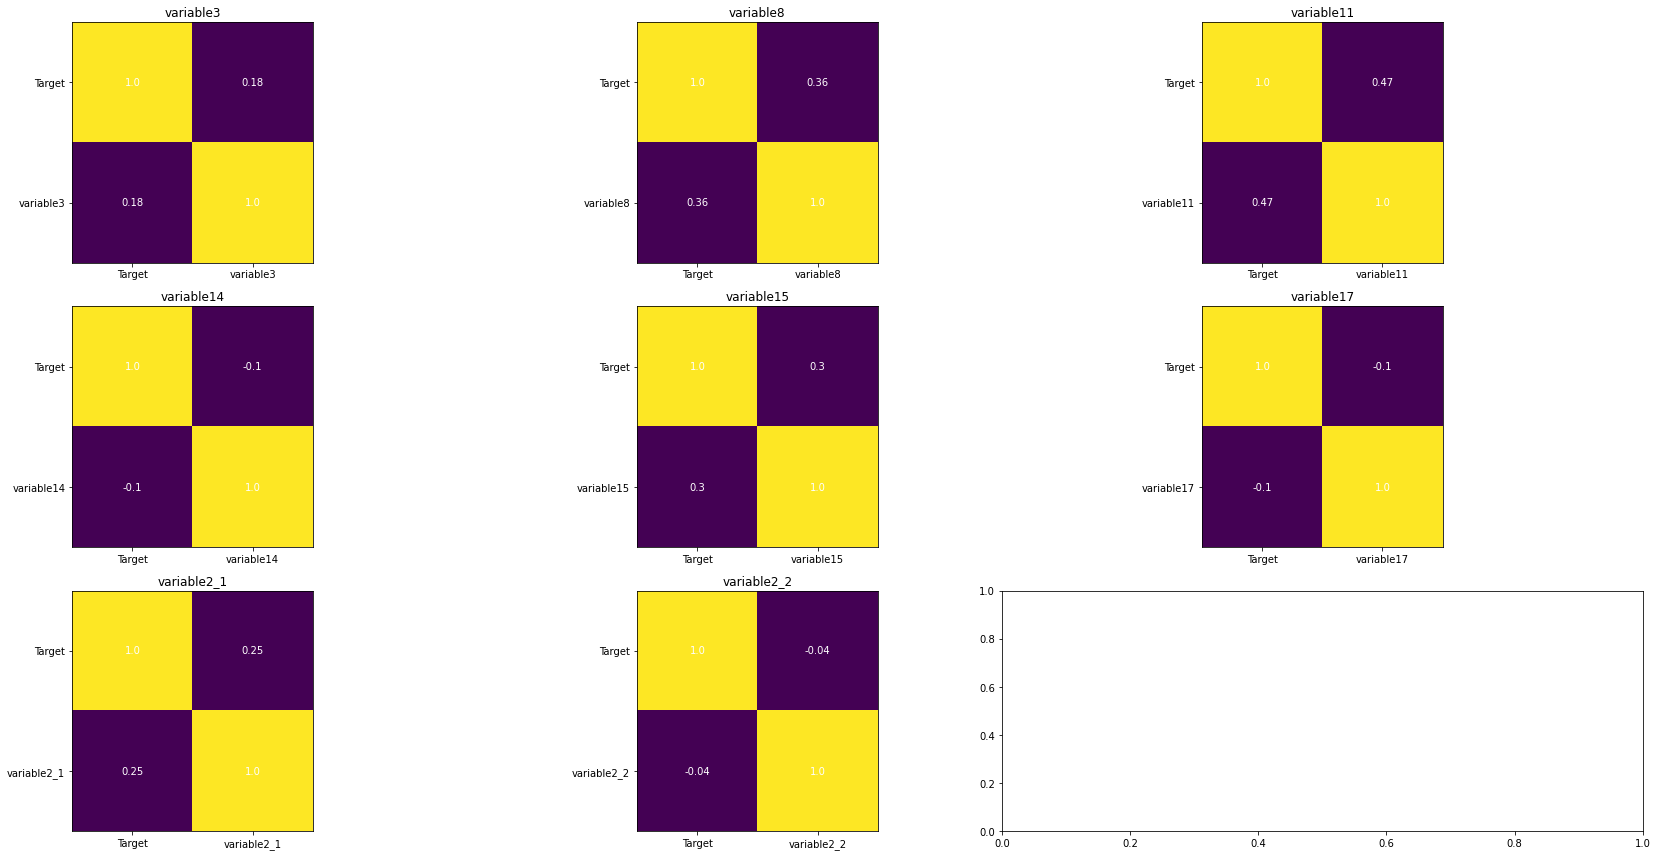

In [14]:
dropped_no_null_val_df = dropped_val_df.drop(['variable18','variable2'],axis=1).dropna()

target = dropped_no_null_val_df['classLabel'].map({'yes.':1,'no.':0}) # I should have done this only once earlier

fig, axs = plt.subplots(3,3,figsize=(25,12))

for idx,feature in enumerate(dropped_no_null_val_df.columns[is_feature_numerical]):
  corr_mat = np.corrcoef(dropped_no_null_val_df[feature].values,target.values)
  corr_mat = np.around(corr_mat,decimals=2)
  draw_matrix_heatmap(corr_mat,['Target',feature],['Target',feature],feature,axs[idx//3][idx%3])
  
fig.tight_layout()
plt.show()

## Quick Observation 3
* variable14 and variable17 are duplicates (validated as variable17 = variable14x10000)
* No noticeable difference between validation and training distributions

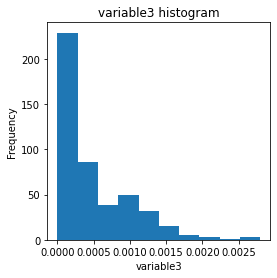

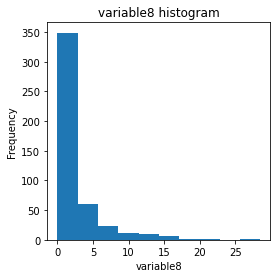

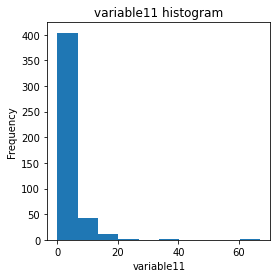

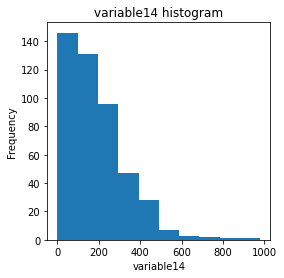

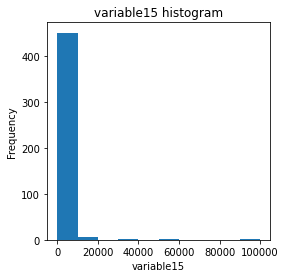

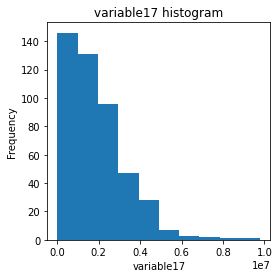

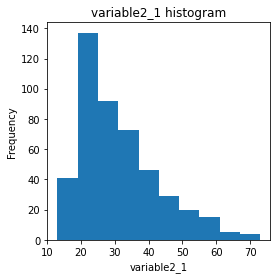

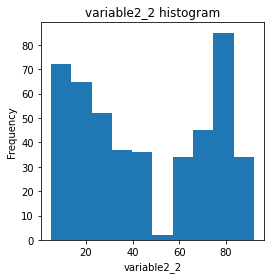

In [15]:
for idx,feature in enumerate(dropped_no_null_df.columns[is_feature_numerical]):
  plt.figure(figsize=(4,4))
  plt.title("{} histogram".format(feature))
  plt.hist(dropped_no_null_df[feature])
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.show()

## Quick Observation 4
variable2_2 seems not to follow a single normal distribution but rather a sum of 2 different distributions. Given, that one of the peaks are similar to variable2_1 it could have been: 
* created by adding another normal distribution with mean around 80 to variable2_1.
* Separating variable2 into 2 columns was not that simple, the singular values (a row with only one value for variable2 and not for example "12,20") might have been not belonging to any of the columns and needed to be in a third separate column. This will be added to further improvement.

# Data Cleaning
## Steps
* Drop duplicates
* Fill missing values for categorical features using mode (other methods could probably be better such as using NMF).
* Fill missing values for variable18 with a new category
* One hot encode all categorical features as I have no context to be able to order the categories for label encoding.
* Split variable 2 into 2 columns
* Parse variable3 and variable8 as some of the entry are strings with "," as the decimal point
* Fill missing values for numerical features using mean (again other methods could probably be better, but for this dataset the categorical features already provide almost all of the information available in the dataset. Numerical features don't contribute that much)
* Normalize numerical features
* Save one hot encoder, normalizing values, and missing value fills to be able to use them to preprocess the validation/test set


In [16]:
from sklearn.preprocessing import OneHotEncoder

to_drop = ['variable5','variable17','variable19']
to_fill_na_cat = ['variable1','variable4','variable6','variable7']
cat_features = ['variable1', 'variable4', 'variable6', 'variable7', 'variable9',
       'variable10', 'variable12', 'variable13', 'variable18','classLabel']
numerical_features = ['variable3','variable8','variable11','variable14','variable15','variable2_1','variable2_2']

enc = OneHotEncoder(handle_unknown='ignore')
means = {}
stds = {}
vals_used_fill_na = {}

def prepare_dataframe_training(df):
  """ Apply data cleaning to training set, details mentioned above

  Args:
    df (pd.DataFrame): Training set dataframe used to create the clean training set

  Returns:
    pd.DataFrame: Cleaned training set dataframe
  """
  # Drop duplicates
  df_clean = df.drop_duplicates().drop(to_drop,axis=1)

  ######## Processing Categorical Features ########

  # Fill NA values for some categorical values using mode
  for feature in to_fill_na_cat:
    cat_feature_mode = df_clean[feature].mode()[0]
    vals_used_fill_na[feature] = cat_feature_mode
    df_clean[feature].fillna(value=cat_feature_mode,inplace=True)
  
  # Third category for nulls in variable18
  df_clean['variable18'].fillna(value='n',inplace=True)

  # One-hot encodings
  encoded_data = enc.fit_transform(df_clean[cat_features]).toarray()
  encoded_df = pd.DataFrame(data=encoded_data,columns=enc.get_feature_names(cat_features)).reset_index()
  df_clean = df_clean.reset_index()

  # Add one-hot encodings as new columns
  for c in encoded_df.columns:
    df_clean[c] = encoded_df[c]
  
  # Remove original categorical columns (leaving only the one-hot encodings)
  df_clean.drop(cat_features,axis=1,inplace=True)


  ######## Processing Numerical Features ########

  # Divide variable2 into 2 columns and delete original variable2 column
  df_clean['variable2_1'],df_clean['variable2_2']  = clean_variable2(df_clean['variable2'])
  df_clean.drop(columns=['variable2'],inplace=True)

  # variable3 and variable8 parse
  df_clean['variable3'] = df_clean['variable3'].apply(clean_string_floats)
  df_clean['variable8'] = df_clean['variable8'].apply(clean_string_floats)

  # Fill missing values for numerical features using mean and normalize
  for feature in numerical_features:
    # Fill missing values using mean
    feature_fill_mean = df_clean[feature].mean()
    vals_used_fill_na[feature] = feature_fill_mean
    df_clean[feature].fillna(value=feature_fill_mean,inplace=True)

    # Normalize
    means[feature] = df_clean[feature].mean()
    stds[feature] = df_clean[feature].std()
    df_clean[feature] = (df_clean[feature].values-means[feature])/stds[feature]

  df_clean = df_clean.drop(['index'],axis=1)
  return df_clean

def prepare_dataframe_test(df):
  """ Apply data cleaning to validation or test set, details mentioned above

  Args:
    df (pd.DataFrame): validation or test set dataframe used to clean/preprocess

  Returns:
    pd.DataFrame: Cleaned dataframe
  """
  df_clean = df.drop(to_drop,axis=1)

  ######## Processing Categorical Features ########

  # Fill NA values for some categorical values using previously used values for training set
  for feature in to_fill_na_cat:
    df_clean[feature].fillna(value=vals_used_fill_na[feature],inplace=True)
  
  # Third category for nulls in variable18
  df_clean['variable18'].fillna(value='n',inplace=True)

  # One-hot encodings using encoder previously fitted on the training set
  encoded_data = enc.transform(df_clean[cat_features]).toarray()
  encoded_df = pd.DataFrame(data=encoded_data,columns=enc.get_feature_names(cat_features)).reset_index()
  df_clean = df_clean.reset_index()
  
  # Add one-hot encodings as new columns
  for c in encoded_df.columns:
    df_clean[c] = encoded_df[c]

  # Remove original categorical columns (leaving only the one-hot encodings)
  df_clean.drop(cat_features,axis=1,inplace=True)


  ######## Processing Numerical Features ########

  # Divide variable2 into 2 columns and delete original variable2 column
  df_clean['variable2_1'],df_clean['variable2_2']  = clean_variable2(df_clean['variable2'])
  df_clean.drop(columns=['variable2'],inplace=True)

  # variable3 and variable8 parse
  df_clean['variable3'] = df_clean['variable3'].apply(clean_string_floats)
  df_clean['variable8'] = df_clean['variable8'].apply(clean_string_floats)

  # Fill missing values for numerical features using mean and normalize
  for idx,feature in enumerate(numerical_features):
    # Fill missing values using previously recorded values from training set
    df_clean[feature].fillna(value=vals_used_fill_na[feature],inplace=True)

    # Normalize using same mean and std collected from the training set
    df_clean[feature] = (df_clean[feature].values-means[feature])/stds[feature]

  df_clean = df_clean.drop(['index'],axis=1)
  return df_clean

In [17]:
# Apply data cleaning to training and validation sets
df = pd.read_csv("training.csv",delimiter=';').sample(frac=1).reset_index(drop=True) # Random shuffling to ensure iid distribution
df = prepare_dataframe_training(df)
df_val = pd.read_csv("validation.csv",delimiter=';').sample(frac=1).reset_index(drop=True) # Random shuffling to ensure iid distribution
df_val = prepare_dataframe_test(df_val)

# Model Hypotheses
This problem is binary classification with simple features some of which have significant correlation with the target labels. Moreover, the dataset size is actually small as most of it were duplicates and were removed previously; therefore, simpler models will be used.

## Models to use and why
* Bayesian Inference using beta and binomial using only variable9: High correlation of variable9 with targets suggest that a very simple model can be created using only it. A simple probabilistic model would allow estimation of confidence values and using specifically the beta and binomial allow online updates.
* Logistic Regression: Simple and perfect for our case of binary classification. Should give the exact same result as bayesian inference if used with variable9 only.
* Decision Trees: given the small number of variables, training this model might give insight into the structure of the dataset. It might not perform the best, but it is worth the try.
* SVM: Given the data cleaning done, using an SVM might work. It would have completely failed without the EDA. (Prediction before training: won't be much better than other models if even better)

## Evaluation
The 4 main metrics (precision, recall, f1, accuracy) for binary classification will be used though just accuracy might be enough because the target classLabels is not significantly biased. (balancing classes added in further improvements)

## Estimated evaluation results (Baseline)
Creating estimates for training results for all models helps ensure no issue was made during training. An estimate can be created using the EDA. Using variable9 and variable10 only, one can reach >85% accuracy on both the training and validation sets using very simple bayesian inference.

I am also predicting that because of the way the data seems to be distributed. variable9 or variable10 will probably be enough to reach that 85% and I am also predicting that no model will perform much above that. This is because a lot of the variables are statistically insignificant and the significant variables seem to be closely related (derived from each other)

# Training Models

In [18]:
training_X = df.drop(['classLabel_no.', 'classLabel_yes.'],axis=1).values
training_Y = df['classLabel_yes.'].values
val_X = df_val.drop(['classLabel_no.', 'classLabel_yes.'],axis=1).values
val_Y = df_val['classLabel_yes.'].values

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def evalute_model_predictions(y_true,y_pred,title):
  """
  """
  fig,ax = plt.subplots()
  draw_matrix_heatmap(confusion_matrix(y_true,y_pred),["a","b"],["c","d"],title,ax)
  plt.show()
  accuracy = (y_true==y_pred).sum()/y_true.shape[0]
  precision, recall, f1, support = precision_recall_fscore_support(y_true,y_pred)
  
  print("Accuracy: {:.3f}".format(accuracy))
  print("Precision: {}".format(precision))
  print("Recall: {}".format(recall))
  print("F1: {}".format(f1))
  print("Support: {}".format(support))

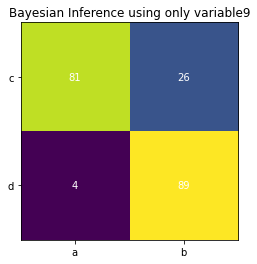

Accuracy: 0.850
Precision: [0.95294118 0.77391304]
Recall: [0.75700935 0.95698925]
F1: [0.84375    0.85576923]
Support: [107  93]


In [20]:
# Bayesian Inference
from scipy.stats import beta

def get_posterior_dist(training_X,training_Y):
  """ Creates a beta posterior distribution from the training data
  the posterior is a functional of x given the pdf of the distribution as a function given x

  Args:
    training_X (pd.Series or np.array): binary feature values for training (only 1 feature)
    training_Y (pd.Series or np.array): binary targets

  Returns:
    function(x,y_prob): given x, function(y_prob) is the beta pdf for the probability that the target takes any particular value y_prob
  """
  a_1 = training_Y[training_X==1].sum()
  b_1 = training_Y[training_X==1].shape[0]-a_1
  
  a_2 = training_Y[training_X==0].sum()
  b_2 = training_Y[training_X==0].shape[0]-a_2
  p_y_given_x = lambda x,p: x*beta.pdf(p,a_1-1,b_1-1) + (1-x)*beta.pdf(p,a_2-1,b_2-1)
  return p_y_given_x

def MAP(posterior,x):
  """ Maximum a Posteriori applied to a pdf given a particular value for the feature (x)

  Args:
    posterior: function(x,y_prob) described in get_posterior_dist function above
    x (int): binary feature
  
  Returns:
    float: most likely probability that y is 1
  """
  max_beta_val = 0
  max_y_prob = 0

  for y_prob in np.arange(0,1,0.05): # There is probably a better/faster way using numpy
    if posterior(x,y_prob) > max_beta_val:
      max_beta_val = posterior(x,y_prob)
      max_y_prob = y_prob
  
  return max_y_prob


# Create posterior for target given value of (variable9=='f')
posterior = get_posterior_dist(df['variable9_f'].values,df['classLabel_yes.'].values)

# Evaluation
preds = []
for x in df_val['variable9_f']:
  pred_y = MAP(posterior,x)>0.5
  preds.append(pred_y)

evalute_model_predictions(val_Y,preds,"Bayesian Inference using only variable9")

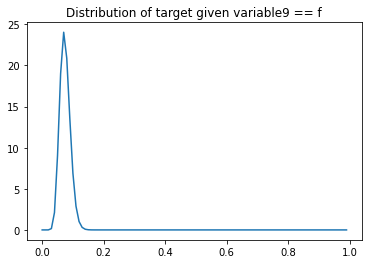

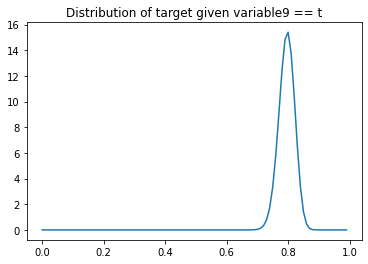

In [21]:
# Bayesian Inference (Drawing distributions)

# variable9 == f
pdf = []
for y_prob in np.arange(0,1,0.01): # There is probably a better/faster way using numpy
    pdf.append(posterior(1,y_prob))

plt.title("Distribution of target given variable9 == f")
plt.plot(np.arange(0,1,0.01),pdf)
plt.show()


# variable9 == t
pdf = []
for y_prob in np.arange(0,1,0.01): # There is probably a better/faster way using numpy
    pdf.append(posterior(0,y_prob))
    
plt.title("Distribution of target given variable9 == t")
plt.plot(np.arange(0,1,0.01),pdf)
plt.show()

## 1 line solution with preprocessing
Using the observations from bayesian inference, variable9 can be used to reach 85% validation accuracy showing how important of a variable it is.

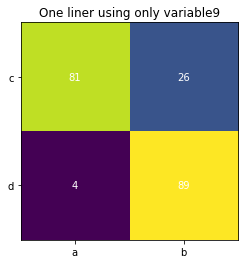

Accuracy: 0.850
Precision: [0.95294118 0.77391304]
Recall: [0.75700935 0.95698925]
F1: [0.84375    0.85576923]
Support: [107  93]


In [22]:
# One line prediction with preprocessing

# 0 or 1 prediction, -1 if data format is not acceptable
model = lambda x: x[8]=='t' if x[8] in ['f','t'] else None

val_data_unprocessed = pd.read_csv("validation.csv",delimiter=";")

# Evaluation
preds = []
for x in val_data_unprocessed.values:
  preds.append(model(x))

preds = np.array(preds,dtype=int)
y_true = val_data_unprocessed['classLabel'].map({'yes.':1,'no.':0}).values
evalute_model_predictions(y_true,preds,"One liner using only variable9")

Training Accuracy: 0.857



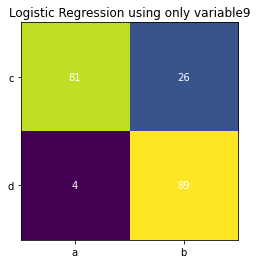

Accuracy: 0.850
Precision: [0.95294118 0.77391304]
Recall: [0.75700935 0.95698925]
F1: [0.84375    0.85576923]
Support: [107  93]


In [23]:
# Logistic Regression (Without feature selection)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
    'penalty':['l2'],
    'C':[0.1,0.5,1.0,5.0,20.0,50.0],
    'solver':['lbfgs']
          }

clf = GridSearchCV(LogisticRegression(random_state=0,max_iter=500), params)
clf.fit(df[['variable9_f']], training_Y)
val_preds = clf.predict(df_val[['variable9_f']])

print("Training Accuracy: {:.3f}\n".format(clf.score(df[['variable9_f']],training_Y)))
evalute_model_predictions(val_Y,val_preds,"Logistic Regression using only variable9")

Training Accuracy: 0.867



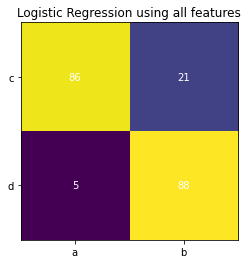

Accuracy: 0.870
Precision: [0.94505495 0.80733945]
Recall: [0.80373832 0.94623656]
F1: [0.86868687 0.87128713]
Support: [107  93]


In [24]:
# Logistic Regression (Without feature selection)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
    'penalty':['l2'],
    'C':[0.1,0.5,1.0,5.0,20.0,50.0],
    'solver':['lbfgs']
          }

clf = GridSearchCV(LogisticRegression(random_state=0,max_iter=500), params)
clf.fit(training_X, training_Y)
val_preds = clf.predict(val_X)

print("Training Accuracy: {:.3f}\n".format(clf.score(training_X,training_Y)))
evalute_model_predictions(val_Y,val_preds,"Logistic Regression using all features")

Training Accuracy: 0.867



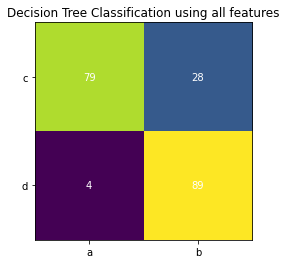

Accuracy: 0.840
Precision: [0.95180723 0.76068376]
Recall: [0.73831776 0.95698925]
F1: [0.83157895 0.84761905]
Support: [107  93]


In [25]:
# Decision Trees (Without feature selection)

from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion':['entropy','gini'],
    'max_leaf_nodes':[5],
    'splitter':['best','random'],
    'max_depth':[5,10,100]
          }

clf = GridSearchCV(DecisionTreeClassifier(random_state=0), params)
clf.fit(training_X, training_Y)
val_preds = clf.predict(val_X)

print("Training Accuracy: {:.3f}\n".format(clf.score(training_X,training_Y)))
evalute_model_predictions(val_Y,val_preds,"Decision Tree Classification using all features")

Training Accuracy: 0.867



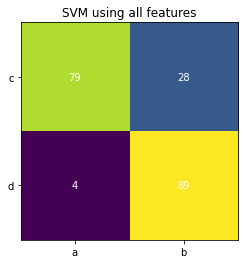

Accuracy: 0.840
Precision: [0.95180723 0.76068376]
Recall: [0.73831776 0.95698925]
F1: [0.83157895 0.84761905]
Support: [107  93]


In [26]:
# SVM
from sklearn.svm import SVC

params = {'kernel':['linear','rbf'],
          'C':[0.3,1,5,20,50]
          }

clf = GridSearchCV(SVC(gamma='auto'), params)
clf.fit(training_X, training_Y)
val_preds = clf.predict(val_X)

print("Training Accuracy: {:.3f}\n".format(clf.score(training_X,training_Y)))
evalute_model_predictions(val_Y,val_preds,"SVM using all features")

# Model Choice and Evaluation
* All the models having similar results reveal how simple the problem is and how stable the cleaned data is. 
* Nothing too unexpected happened with the different metrics. The one observation might be that fact that the models was more precise with negative examples. This is expected since the training data had more negative examples compared to positive examples. (Added to further improvements)
* SVM getting the same results as simple Bayesian Inference, Logistic Regression, and Decision Trees show that the problem is mostly linear. 
* All models also show that variable9 is the most important which confirms previous suspicion in that it is the main column most correlated with the target with other columns not providing that much extra data meaning that they were either derived in the same way as variable9 or were derived from variable9.
* The best model is the Logistic Regression model using all features. Some feature selection could be added later to simplify the model further. (Added to further improvements)
* The Bayesian Inference method will be used in the API since it is the most simple, uses only variable9, achieves results as good as the other models, allows for calculation of confidence intervals, has a low computational cost during both training and inference, can allow for efficient online updates if needed.

# API (very simple and not needed)


The simplicity of the solution means that >85% accuracy can be reached using one line of code. It doesn't actually need an API for Bayesian Inference. However, the API can be used as a start to launch the logistic regression model on.
<br>
API brief documentation can be found [here](https://level-unequaled-salto.glitch.me/)

In [27]:
import requests

# Example Usage
API_KEY = 'INSERT API KEY SENT BY EMAIL HERE'
response = requests.post('https://level-unequaled-salto.glitch.me/inference', json={"inference_data":"['f','t',2]",
                                                                             "api_key":API_KEY,
                                                                             "type":"simple"})

print("Request status code: {}".format(response.status_code))
print("Request results: {}".format(response.json()['predictions']))

Request status code: 200
Request results: [0, 1, "Feature input format not accepted (use 1 character either 'f' or 't')"]


# Further Improvements
* Analysis of the features' relations to each other not just with target
* variable2 could be divided into 3 columns not 2 as currently done. See "Quick observation 4".
* Use feature selection along with the Logistic Regression model using all features to create the simplest model with best performance possible.
* Check if class balancing results in an improvement
* Use NMF or Probabilistic PCA to fill missing values for categorical features especially variable9, I am estimating that this could probably increase the validation accuracy to 90%. This is because of the high correlation between the different features which means guessing the missing values for variable9 could probably be done with good accuracy.
* Conclude (statistically prove) that features other than variable9 are or are not useful and extend API to include the other features if needed.